# WEEK 4 CODE

### Content:
* TASK 1: Detect keypoints and compute descriptors in Museum and query images
* TASK 2: Find tentative matches based on similarity of local appearance and verify matches
* TASK 3: Evaluate the system on QSD1-W4, map@k
* TASK 4: Evaluate best system from previous week on QSD1-W4


In [1]:
#IMPORTS
import sys
import cv2
import os
import os.path
import numpy as np
import math
np.set_printoptions(threshold=np.inf)
import matplotlib.patches as patches
import ml_metrics as metrics
import pickle
from matplotlib import pyplot as plt
from os.path import isfile, join
from os import listdir
from sklearn import preprocessing
from sklearn.metrics import recall_score,precision_score,f1_score
from scipy.spatial import distance
from scipy.signal import convolve2d
from scipy.fftpack import dct
from scipy import ndimage
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage.filters import roberts, sobel, sobel_h, sobel_v
from skimage.morphology import skeletonize, dilation, square, opening, closing, erosion
from pathlib import Path
from cv2 import boundingRect
from cv2 import xfeatures2d_SIFT
from PIL import Image, ImageDraw
import pytesseract

# Pre-processing: Filter noise with linear or non-linear filters

In [ ]:
# DEFINE FUNCTIONS 

def detectnoise(img):
    # Calcula la sigma del soroll. Llavors les imatges que tenen soroll tenen una sigma més gran 
    #que la resta de les imatges
    thr = 8.0
    H, W = gray.shape

    M = [[1, -2, 1],
        [-2, 4, -2],
        [1, -2, 1]]
    
    sigma = np.sum(np.sum(np.absolute(convolve2d(gray, M))))
    sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))
    if sigma>thr:
        return True
    else:
        return False


In [ ]:
query2folder = './qsd1_w4/'

# CREEM UN DIRECTORI ON GUARDEM LES IMATGES SENSE SOROLL
path = 'qsd1_w4_denoise'
if not os.path.exists(path):
    os.mkdir(path)


for filename in sorted(listdir(query2folder)):
    if(filename != '.DS_Store' and ('jpg' in filename)):
        print ("\r Processing image...   {}".format(query2folder+filename), end="")
        query_img = cv2.imread(query2folder + filename)
        gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
        noise = detectnoise(gray)
        if noise:
            denoise_img = cv2.bilateralFilter(query_img, 9, 120, 120)
            denoise_img_2 = cv2.fastNlMeansDenoisingColored(denoise_img,None,12,10,7,21) 
        else:
            denoise_img_2 = query_img
        
        cv2.imwrite(os.path.join(path,filename), denoise_img_2)

            
        

# Task 1: Detect keypoints and compute descriptors

In [3]:
#DEFINING FUNCTIONS FOR TASK 1

def findKeypoints(img, descriptor):
    
    if descriptor is 'SIFT':
        # Initiate SIFT detector
        sift = xfeatures2d_SIFT.create()

        # find the keypoints and descriptors with SIFT
        kp, des = sift.detectAndCompute(img, None)
    elif descriptor is 'ORB':
        # Initiate ORB detector
        orb = cv2.ORB_create()
        
        # find the keypoints and descriptors with ORB
        kp = orb.detect(img, None)
        kp, des = orb.compute(img, kp)
    
    elif descriptor is 'SURF':
        # Initiate SURF detector
        surf = xfeatures2d_SURF.create()

        # find the keypoints and descriptors with SIFT
        kp, des = surf.detectAndCompute(img, None)

    return kp,des


# FUNCTIONS BACKGROUND DETECTION 

def detect_corners(mask):
    """
    Finds four points corresponding to rectangle corners

    :param mask: (ndarray) binary image
    :return: (int) points from corners
    """

    width = mask.shape[1]
    height = mask.shape[0]
    coords = np.argwhere(np.ones([height, width]))
    coords_x = coords[:, 1]
    coords_y = coords[:, 0]

    coords_x_filtered = np.extract(mask, coords_x)
    coords_y_filtered = np.extract(mask, coords_y)
    max_br = np.argmax(coords_x_filtered + coords_y_filtered)
    max_tr = np.argmax(coords_x_filtered - coords_y_filtered)
    max_tl = np.argmax(-coords_x_filtered - coords_y_filtered)
    max_bl = np.argmax(-coords_x_filtered + coords_y_filtered)

    tl_x, tl_y = int(coords_x_filtered[max_tl]), int(coords_y_filtered[max_tl])
    tr_x, tr_y = int(coords_x_filtered[max_tr]), int(coords_y_filtered[max_tr])
    bl_x, bl_y = int(coords_x_filtered[max_bl]), int(coords_y_filtered[max_bl])
    br_x, br_y = int(coords_x_filtered[max_br]), int(coords_y_filtered[max_br])

    return tl_x, tl_y, bl_x, bl_y, br_x, br_y, tr_x, tr_y

def waterShed(query_img, color_space, sat_chan):
    """
    Applies watershed to detect foreground and baskground

    :param query_img: (ndarray) query image
    :param sat: (ndarray) query image saturation
    :param part: (int) one paint(0), two paints left part(1),  two paints right part(2)
    :return: mask: predicted mask
    """
    
    if sat_chan:
        ret, thresh = cv2.threshold(color_space, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        thresh_pos = np.where(thresh==255)
        if np.sum(thresh_pos[0]==0)>.7*thresh.shape[0] or np.sum(thresh_pos[1]==0)>.7*thresh.shape[1]:
            thresh = 255 - thresh
    else:
        thresh = k_means(color_space)
        thresh_pos = np.where(thresh==255)
        if np.sum(thresh_pos[0]==0)>.7*thresh.shape[0] or np.sum(thresh_pos[1]==0)>.7*thresh.shape[1]:
            thresh = 255 - thresh
    
    # noise removal
    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    # fillin holes
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel, iterations=2)

    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)  # Fals. El sure

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
    ret, sure_fg = cv2.threshold(dist_transform, 0.05 * dist_transform.max(), 255, 0)  # 0.15 26.57%

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    markers[markers != 0] = 200

    border_top = int(sat.shape[0] * .03)
    borde_lat = int(sat.shape[1] * .02)

    # define known sure background
    markers[0:border_top, :] = 100
    sure_fg[0:border_top, :] = 100

    markers[len(markers) - border_top:len(markers) - 1, :] = 100
    sure_fg[len(markers) - border_top:len(markers) - 1, :] = 100

    markers[:, 0:borde_lat] = 100
    sure_fg[:, 0:borde_lat] = 100
    markers[:, len(markers[0, :]) - borde_lat:len(markers[0, :]) - 1] = 100
    sure_fg[:, len(markers[0, :]) - borde_lat:len(markers[0, :]) - 1] = 100

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[sure_fg == 0] = 0

    markersres = cv2.watershed(query_img, markers)

    markersres[markersres == 201] = 255
    markersres[markersres == 101] = 0
    markersres[markersres == -1] = 255

    # Make the mask binary
    markersres = markersres / np.max(markersres)
            
    # Remove imperfections with morphological filers (noise)
    markersres = cv2.morphologyEx(markersres, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)

    # Set predicted mask
    mask_pred = markersres.astype('uint8')

    # Get connected components
    ret, labels = cv2.connectedComponents(mask_pred)

    # Initialize mask for paintings
    mask = np.zeros((mask_pred.shape[0], mask_pred.shape[1], 2), dtype="uint8")

    # If exist more than two connected components (background and one painting)
    if ret > 2:

        # Compute area of each connected component
        area = []
        for i, lab in enumerate(np.unique(labels)):
            area.append(mask_pred[labels == lab].size)

        # Sort indexes from length of areas
        idx = sorted(range(len(area)), key=lambda k: area[k])

        # Check if more than three connected components (background and two paintings)
        if ret > 3:
            for i, j in enumerate(idx):
                # Remove smallest areas
                if (len(area)-i) > 3:
                    mask_pred[labels == j] = 0

        # Remove indexes labels where its pixels are now zero
        idx = [n for _, n in enumerate(idx) if np.sum(mask_pred[labels == n]) != 0]

        # Positions of non-zero elements of each painting
        obj1 = np.where(labels == idx[0])
        obj2 = np.where(labels == idx[1])

        # Determine if there exist two paintings
        if (area[idx[0]] > .28*area[idx[1]]):

            # Check that one connected component is not inside the other
            if (((np.min(obj1[1][:]) - np.max(obj2[1][:])) < 0) and ((np.max(obj1[1][:]) - np.min(obj2[1][:])) > 0)) \
                    or (((np.min(obj2[1][:]) - np.max(obj1[1][:])) < 0) and
                        ((np.max(obj2[1][:]) - np.min(obj1[1][:])) > 0)):
                mask = mask_pred
            else:
                # Set one mask to each painting
                mask[labels == idx[0], 0] = 1
                mask[labels == idx[1], 1] = 1

        else:
            # Set mask for the painting
            mask = mask_pred

    else:
        # Set mask for the painting
        mask = mask_pred

    ## POLYGON - Generate a polygon from mask corners ##

    mask_f = np.zeros((mask_pred.shape[0], mask_pred.shape[1], 2), dtype="uint8")

    # For two paintings
    if len(mask.shape) > 2:
        # Get Corners
        corners0 = detect_corners(mask[:, :, 0])

        # Draw polygon
        poly0 = Image.new('RGB', (mask_pred.shape[1], mask_pred.shape[0]), (0))
        pdraw0 = ImageDraw.Draw(poly0)
        pdraw0.polygon(xy=corners0, fill=(1), outline=None)
        mask_pred_f = np.array(poly0)[:, :, 0]
        mask_f[:, :, 0] = mask_pred_f

        # Get Corners
        corners1 = detect_corners(mask[:, :, 1])

        # Draw polygon
        poly1 = Image.new('RGB', (mask_pred.shape[1], mask_pred.shape[0]), (0))
        pdraw1 = ImageDraw.Draw(poly1)
        pdraw1.polygon(xy=corners1, fill=(1), outline=None)
        mask_f[:, :, 1] = np.array(poly1)[:, :, 0]
        mask_pred_f = mask_pred_f + mask_f[:, :, 1]

    # Just one painting
    else:
        # Get Corners
        corners = detect_corners(mask)

        # Draw polygon
        poly = Image.new('RGB', (mask_pred.shape[1], mask_pred.shape[0]), (0))
        pdraw = ImageDraw.Draw(poly)
        pdraw.polygon(xy=corners, fill=(1), outline=None)
        mask_pred_f = np.array(poly)[:, :, 0]
        mask_f = mask_pred_f

    return mask_pred_f, mask_f


def k_means(color_space):
    
    Z = color_space.reshape((-1))
    # convert to np.float32
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(Z, 5, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((gray.shape))

    mask = np.zeros(color_space.shape[:2],np.uint8)

    for l in range(len(center)):
        lab_pos = np.where(res2==center[l])
        if any(lab_pos[0]==0) or any(lab_pos[1]==0) or any(lab_pos[0]==color_space.shape[0]-1) or any(lab_pos[1]==color_space.shape[1]-1):
            continue
        else:
            mask[lab_pos[0],lab_pos[1]] = 255
    
    if np.sum(mask) == 0:
        pos = np.where(res2==res2[int(color_space.shape[0]/2),int(color_space.shape[1]/2)])
        mask[pos[0],pos[1]] = 255
        
    return mask


def crop(query_im, mask_crop):
    # Coordinates of non-black pixels.
    coords = np.argwhere(mask_crop)

    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1 # slices are exclusive at the top

    # Get the contents of the bounding box.
    cropped = query_im[x0:x1, y0:y1]
    mask_cropped = mask_crop[x0:x1, y0:y1]

    return cropped, mask_cropped, x0, y0



#### Define Parameters

In [72]:
# DEFINING GLOBAL VARIABLES

descriptor = 'ORB'

if descriptor is 'SIFT':
    method = 'FLANN'
    resize_factor = 1/4
    MIN_MATCHES = 80
    
elif descriptor is 'ORB':
    method = 'BRUTE_FORCE'
    resize_factor = 1/4
    MIN_MATCHES = 20
    
elif descriptor is 'SURF':
    method = 'FLANN'
    resize_factor = 1/4
    MIN_MATCHES = 80


### BBDD

In [73]:
folder = './bbdd/'
kp_bbdd_array = []
des_bbdd_array = []

for filename in sorted(listdir(folder)):
    if(filename != '.DS_Store' and ('jpg' in filename)):
        print ("\r Processing image...   {}".format(folder+filename), end="")
        img = cv2.imread(folder + filename,0)#0 is the way of getting B&W image
        height, width = img.shape[:2]
        resize_size = (int(width*resize_factor), int(height*resize_factor))
        img_res = cv2.resize(img, resize_size)
        kp_bbdd, des_bbdd = findKeypoints(img_res, descriptor)
        kp_bbdd_array.append(kp_bbdd)
        des_bbdd_array.append(des_bbdd)
        

 Processing image...   ./bbdd/bbdd_00278.jpg

### QSD1_W4

#### Create masks

 Processing image...   ./qsd1_w4_denoise/00001.jpg

KeyboardInterrupt: 

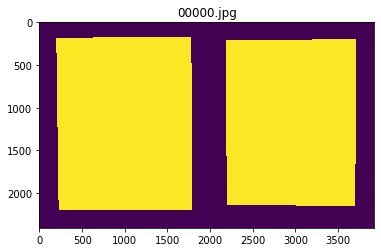

In [6]:
folder = './qsd1_w4_denoise/'
kp_query_array = []
des_query_array = []
numPaintings = []

for filename in sorted(listdir(folder)):
    if(filename != '.DS_Store' and ('jpg' in filename)):
        print ("\r Processing image...   {}".format(folder+filename), end="")
        img = cv2.imread(folder + filename) #0 is the way of getting B&W image
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Get saturation and grayscale from query image
        sat = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,1]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if ndimage.variance(sat)<ndimage.variance(gray):
            color_space = gray
            sat_channel=False
            
        else:
            color_space = sat
            sat_channel=True
            
        # Predict mask
        mask_pred,mask = waterShed(img, color_space, sat_channel)
        
        plt.figure()
        plt.imshow(mask_pred)
        plt.title(filename)
        
        # Save masks
        path = './masks_qd'
        if not os.path.exists(path):
            os.mkdir(path)

        cv2.imwrite('masks_qd/'+filename[:-4]+'.png',mask_pred*255)
        if len(mask.shape) > 2:
            cv2.imwrite('masks_qd/mask_'+filename[:-4]+'_0.png',mask[:,:,0]*255)
            cv2.imwrite('masks_qd/mask_'+filename[:-4]+'_1.png',mask[:,:,1]*255)
            numPaintings.append([2])
        else:
            cv2.imwrite('masks_qd/mask_'+filename[:-4]+'_0.png',mask[:,:]*255)
            numPaintings.append([1])
        

#### Detect keypoints for cropped images

In [74]:
query2masks = './masks_qd/'
query2folder = './qsd1_w4_denoise/'

kp_query_array = []
des_query_array = []

#COMPUTE SIFT FOR THOSE IMAGES WITHOUT BACKGROUND
for filename in sorted(listdir(query2folder)):
    if (filename != '.DS_Store' and ('jpg' in filename)):
        print ("\r Processing image...   {}".format(query2folder+filename), end="")
        query_img = cv2.imread(query2folder + filename)

        #cropped, mask_cropped, X0, Y0 = crop(query_img,mask)

        height, width = query_img.shape[:2]
        resize_size = (int(width*resize_factor), int(height*resize_factor))
        img_res = cv2.resize(query_img, resize_size)
        kp_query, des_query = findKeypoints(img_res, descriptor)
        kp_query_array.append(kp_query)
        des_query_array.append(des_query)


 Processing image...   ./qsd1_w4_denoise/00029.jpg

# TASK 2: Find matches based on the descriptors obtained on Task 1

In [9]:
#DEFINING FUNCTIONS FOR TASK 2

def findMatches(kp1, kp2, des1, des2, method, MIN_MATCH_COUNT = 10):
    
    if method is 'BRUTE_FORCE':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        good = bf.match(des1, des2)
        
    elif method is 'FLANN':
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)

        # BFMatcher with default params
        FLANN_INDEX_KDTREE = 1
        index_params= dict(algorithm = FLANN_INDEX_KDTREE,
                             trees = 5)
        search_param = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2, k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)
    
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel()

    else:
        matchesMask = 0
    
    numMatches = np.sum(matchesMask)
    
    return numMatches

In [ ]:
MIN_MATCH_COUNT = 10
numMatches_list = []

for i in range(len(kp_query_array)):
    numMatches_array = []
    print ("\nkp_query_array...   {}".format(i))
    for j in range(len(kp_bbdd_array)):
        if (des_query_array[i] is not None):
            print ("\rdes_query_array...   {}".format(j), end="")
            numMatches = findMatches(kp_bbdd_array[j], kp_query_array[i], des_bbdd_array[j], 
                              des_query_array[i], method, MIN_MATCH_COUNT)
            numMatches_array.append(numMatches)
        else:
            numMatches_array.append(0)
        
    numMatches_list.append(np.asarray(numMatches_array))




kp_query_array...   0
des_query_array...   278
kp_query_array...   1
des_query_array...   278
kp_query_array...   2
des_query_array...   278
kp_query_array...   3
des_query_array...   278
kp_query_array...   4
des_query_array...   278
kp_query_array...   5
des_query_array...   278
kp_query_array...   6
des_query_array...   278
kp_query_array...   7
des_query_array...   278
kp_query_array...   8
des_query_array...   278
kp_query_array...   9
des_query_array...   278
kp_query_array...   10
des_query_array...   278
kp_query_array...   11
des_query_array...   278
kp_query_array...   12
des_query_array...   278
kp_query_array...   13
des_query_array...   278
kp_query_array...   14
des_query_array...   278
kp_query_array...   15
des_query_array...   278
kp_query_array...   16
des_query_array...   278
kp_query_array...   17
des_query_array...   278
kp_query_array...   18
des_query_array...   278
kp_query_array...   19
des_query_array...   278
kp_query_array...   20
des_query_array...   201

In [11]:
folder = './qsd1_w4/'
maskfolder = './masks_qd'
kp_query_array = []
des_query_array = []
numPaintings = []

for filename in sorted(listdir(folder)):
    if (filename != '.DS_Store' and ('jpg' in filename)):
        commonName = filename[0:5]
        #print(commonName)
    if(('mask_'+ commonName + '_1.png') in listdir(maskfolder)):
        numPaintings.append([2])
    else:
        numPaintings.append([1])

In [68]:

result = []
K = 10

for i in range(len(numMatches_list)):
    maxim = np.max(numMatches_list[i])
    
    if (numPaintings[i] == [2]):
        if (maxim != 0):
            pos = np.where(numMatches_list[i] == maxim)
            non_maxim = np.delete(numMatches_list[i], pos)
        else:
            non_maxim = numMatches_list[i]
        if (maxim > MIN_MATCHES):
            imgs_max1 = np.argsort(-numMatches_list[i])[:K]
        else:
            imgs_max1 = np.argsort(-numMatches_list[i])[:K-1]
            imgs_max1 = np.insert(imgs_max1,0,-1)

        result.append([imgs_max1.tolist(), imgs_max1.tolist()])
    else:
        non_maxim = numMatches_list[i]
        if (np.max(non_maxim) > MIN_MATCHES):
            imgs = np.argsort(-non_maxim)[:K]
        else:
            imgs = np.argsort(-non_maxim)[:K-1]
            imgs = np.insert(imgs,0,-1)
            
        result.append([imgs.tolist()])

    

# TASK 3:  Evaluate the system on QSD1-W4, map@k

In [71]:
with open('./qsd1_w4/gt_corresps.pkl', 'rb') as fd:
    ll = pickle.load(fd)
    

gt = [[j] if len(j)==1 else [[j[0]],[j[1]]] for j in ll]  
mapk = np.mean([metrics.average_precision.mapk(a,p,3) for a,p in zip(gt, result)])
print(mapk*100)

48.333333333333336


# TASK 4: Evaluate best system from previous week on QSD1-W4

## Texture descriptor

### Implement texture descriptors 
Descriptors:
* Color
* HoG
* Text

In [ ]:
def colorDescriptor(img,level,numberBins):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2Lab)
    
    #Calculem tamany del block
    height, width = img.shape[:2]
    block_height = int(height/level)
    block_width = int(width/level)
    hist_img = np.empty([0,0])
    colorx = ('x','y','z')
    canal = 0
    for i,col in enumerate(colorx): #Bucle per recorrer els canals de cada imatge  
        for r in range(level): #Bucle per recorrer els blocs d'una mateixa row
            for c in range(level): #Bucle per recorrer els blocs d'una mateixa column
                
                block = img[r*block_height:r*block_height+block_height, c*block_width:c*block_width+block_width] 
                hist = cv2.calcHist([block],[i],None,[numberBins],[0,256]) #Calculem histogrames per blocs
                hist_t = hist.transpose()      
                #print(hist_t.shape)
                #print(hist_img.shape)
                if (i==0) and (r==0) and (c==0):
                    hist_img = hist_t
                else:
                    hist_img = np.concatenate((hist_img, hist_t), axis = 1)

    cv2.normalize(hist_img, hist_img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist_img

In [ ]:
def HogDescriptor(img):
    hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8))
    
    return hog_image.ravel()

### Test query system using QSD1-W2 using only texture descriptors

#### 1. Define Parameters

In [ ]:
# DEFINING GLOBAL VARIABLES
Level = 1
numberBins_color = 256

#### 2. Compute BBDD descriptors

In [ ]:
folder = './bbdd/'
histogram_bbdd_matrix_color = []
histogram_bbdd_matrix_texture = []

for filename in sorted(listdir(folder)):
    if(filename != '.DS_Store' and ('jpg' in filename)):
        print ("\r Processing image...   {}".format(folder+filename), end="")
        img = cv2.imread(folder + filename)
        
        equ = np.zeros(img.shape[:], np.uint8)
        for c in range(3):
            equ[:,:,c] = cv2.equalizeHist(img[:,:,c])
        
        #COLOR
        hist_img_color = colorDescriptor(equ,Level,numberBins_color)
        histogram_bbdd_matrix_color.append(hist_img_color)

        #TEXTURE
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image_shape = img.shape[:2]
        image = cv2.resize(img, (200, 200))
        hist_img_texture = HogDescriptor(image)
        hist_img_texture = np.array(hist_img_texture).flatten()
        histogram_bbdd_matrix_texture.append(hist_img_texture)
        
histogram_bbdd_matrix_color = np.asarray(histogram_bbdd_matrix_color)
histogram_bbdd_matrix_texture = np.asarray(histogram_bbdd_matrix_texture)

In [ ]:
import codecs
# Read txt from bbdd_text
textfolder = './bbdd_text/'
bbdd_text = []
for filename in sorted(listdir(textfolder)):
    if(filename != '.DS_Store' and ('txt' in filename)):
        with codecs.open(textfolder + filename,'r',encoding='latin1') as f:
            if  os.stat(textfolder + filename).st_size == 0:
                line = ''
                bbdd_text.append(line)
                #print(filename + line)
            else:
                for line in f.readlines():
                    lim1 = line.find("'",1)
                    lim2 = line.find("'",2)
                    bbdd_text.append(line[lim1+1:lim2])

#### 3. Compute qsd1_w4 descriptors

In [ ]:
histogram_query_matrix_color = []
histogram_query_matrix_texture = []
query_text = []

query2masks = './masks_qt/'
query2folder = './qst1_w4_denoise/'

result2 = []

with open('qst1_w4_text.pkl', 'rb') as fd:
    ll = pickle.load(fd)

for filename in sorted(listdir(query2masks)):
    if (filename != '.DS_Store' and ('png' in filename) and ('mask' in filename)):
        print ("\r Processing image...   {}".format(query2masks+filename), end="")
        
        mask = cv2.imread(query2masks + filename)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        img_num = filename[5:10]
        num_paint = int(filename[-5])
        
        if (num_paint == 0) and (len(result2) != int(img_num)-1):
            result2.append([])
            
        result2[int(img_num)].append([])
        
        img = cv2.imread(query2folder + img_num + '.jpg')
        
        cropped, mask_cropped, X0, Y0 = crop(img,mask)
        
        equ = np.zeros(img.shape[:], np.uint8)
        for c in range(3):
            equ[:,:,c] = cv2.equalizeHist(img[:,:,c])
        
        #COLOR
        hist_img_color = colorDescriptor(equ,Level,numberBins_color)
        histogram_query_matrix_color.append(hist_img_color)

        #TEXTURE
        img = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        image_shape = img.shape[:2]
        image = cv2.resize(img, (200, 200))
        hist_img_texture = HogDescriptor(image)
        hist_img_texture = np.array(hist_img_texture).flatten()
        histogram_query_matrix_texture.append(hist_img_texture)
        
        img = cropped[ll[int(img_num)][num_paint][1]:ll[int(img_num)][num_paint][3],ll[int(img_num)][num_paint][0]:ll[int(img_num)][num_paint][2]]
        if img.shape[0]<4:
            query_text.append('')
        else:
            extractedInformation = pytesseract.image_to_string(img)
            query_text.append(extractedInformation)
        
        with open(img_num+'.txt', 'a') as txtf:
            if num_paint==0:
                txtf.write(extractedInformation)
            else:
                txtf.write('\n'+extractedInformation)
            txtf.close()
        
histogram_query_matrix_color = np.asarray(histogram_query_matrix_color)
histogram_query_matrix_texture = np.asarray(histogram_query_matrix_texture)

#### 4. Evaluation

In [ ]:
# DEFINE EVALUATION FUNCTIONS

def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    #print (matrix)
    return (matrix[size_x - 1, size_y - 1])

def computeMatrixRetrieval_all(histogram_bbdd_color, histogram_query_color, histogram_bbdd_tex, histogram_query_tex, bbdd_text, query_text, K=10):
    num_paint = histogram_query_color.shape[0]
    
    dst_color = np.zeros((num_paint, 279))
    dst_tex = np.zeros((num_paint, 279))
    dst_text = np.zeros((num_paint, 279))
    matrix_retrieval = []

    for query_image_index_c in range(0,len(histogram_query_color)): 
        for bbdd_image_index_c in range(0, len(histogram_bbdd_color)):
            
            dst_color[query_image_index_c,bbdd_image_index_c] = distance.braycurtis(histogram_query_color[query_image_index_c,:], histogram_bbdd_color[bbdd_image_index_c,:])
            dst_tex[query_image_index_c,bbdd_image_index_c] = distance.braycurtis(histogram_query_tex[query_image_index_c,:], histogram_bbdd_tex[bbdd_image_index_c,:])
    
    for query_text_index in range(0,len(query_text)):
        for bbdd_text_index in range(0,len(bbdd_text)-1):
            dst_text[query_text_index,bbdd_text_index] = levenshtein(query_text[query_text_index], bbdd_text[bbdd_text_index])       
       
    
    for query_image_index in range(0,len(dst_tex)):
        matrix_retrieval_color = np.argsort(dst_color[query_image_index,:])[:K]
        matrix_retrieval_tex = np.argsort(dst_tex[query_image_index,:])[:K]
        
        dst_text_idx_sorted = np.argsort(dst_text[query_image_index,:])
        dst_text_sorted = dst_text[query_image_index, dst_text_idx_sorted]<5
        
        matrix_retrieval_text = dst_text_idx_sorted[:np.sum(dst_text_sorted==True)]
        
        most_possible = [int(i) for i in matrix_retrieval_tex.tolist() if i in matrix_retrieval_text.tolist()]
        
        if len(most_possible)<K:
            
            dst = 1*(dst_tex[query_image_index,:])+ 0*(dst_color[query_image_index,:])
            dst_idx_sorted = np.argsort(dst)
            
            not_in_most_possible = [int(i) for i in dst_idx_sorted.tolist() if int(i) not in most_possible][:K-len(most_possible)]
            
            if (not most_possible) and (dst[not_in_most_possible[0]]>.25):
                most_possible = [-1]
                
            most_possible = most_possible + not_in_most_possible[:K-len(most_possible)]
        
        matrix_retrieval.append(most_possible[:K])
    
    return matrix_retrieval

In [ ]:
K=10
matrix_retrieval = computeMatrixRetrieval_all(histogram_bbdd_matrix_color, histogram_query_matrix_color, histogram_bbdd_matrix_texture, histogram_query_matrix_texture, bbdd_text, query_text, K)

count = 0
for i in range(len(result2)):
    for j in range(len(result2[i])):
        result2[i][j] = matrix_retrieval[count]
        count+=1


In [ ]:
with open('./qsd1_w4/gt_corresps.pkl', 'rb') as fd:
    ll = pickle.load(fd)
    

gt = [[j] if len(j)==1 else [[j[0]],[j[1]]] for j in ll]  
mapk = np.mean([metrics.average_precision.mapk(a,p,3) for a,p in zip(gt, result2)])
print(mapk*100)
